In [1]:
#set adequate flag for Theano on lxplus
import theano
theano.config.gcc.cxxflags = '-march=corei7'

In [2]:
#check config
import keras.backend as K
K.set_image_dim_ordering('th')
#print 'Keras backend:', K.backend()
#print 'Keras image ordering operator: ', K.image_dim_ordering()

Using Theano backend.


In [3]:
#load needed things
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import ROOT
import itertools
import math

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [4]:
#boost particles
def boostToHiggs(p4Origin):
    HiggsBoostVector = p4Origin[0].BoostVector()    
    p4Boosted = []
    for ip in range(len(p4Origin)):
        p4O = p4Origin[ip]
        p4O.Boost(-HiggsBoostVector)
        p4Boosted.append( p4O )
    
    #print 'p4Boosted'
    #print p4Boosted
    return p4Boosted

In [5]:
#shifts the subjets towards the 1st PFJet based on the highest pt subjet
#eta'_i = eta_i - eta_0
#phi'_i = phi_i - phi_0
def translate(etas, phis, pts):
    xShift = []
    yShift = []
    
    #center based on Higgs
    xCenter = etas[0]
    yCenter = phis[0]
    
    for ix, iy in zip(etas, phis):
        xShift.append( ix - xCenter )
        yShift.append( iy - yCenter )

    
    return xShift, yShift

In [24]:
#rotation not applied directly on eta-phi plane to preserve Lorentz invariances
#the rotation is likely done around px
def rotate(etas, phis, pts):
    #rotating such Z1 is always at 90 degrees
    pt = pts[1]
    py = pt*math.sin(phis[1])
    pz = pt*math.sinh(etas[1])
    #computes the rotation angle
    v = np.arctan2(py,pz) + np.radians(90)

    rot_x = []
    rot_y = []
    #creates a rotation matrix
    c, s = np.cos(v), np.sin(v)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))

    for ix, iy, iw in zip(etas, phis, pts):
        #original components
        px = iw*math.cos(iy)
        py = iw*math.sin(iy)
        pz = iw*math.sinh(ix)

        #transforms components
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        
        rot_x.append(rix)
        rot_y.append(riy)
        
    return rot_x, rot_y

In [7]:
#accounts for assymetry on energy distribution
#keeps the jet average pt always in eta' positive range
def reflect(x, w):
    leftSum = 0
    rightSum = 0
    for ix, iw in zip(x, w):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
                        
    if(leftSum > rightSum):
        ref_x = [e*(-1) for e in x]
        return ref_x
    else:
        return x

In [8]:
#nx size of image in eta
#ny size of image in phi
def prepareImages(inputs, nx, xmin, xmax, ny, ymin, ymax, pre_process):
    nevents = len(inputs)
    
    list_x = []
    list_y = []
    list_w = []

    #determines the pixel of picture
    xbins = np.linspace(xmin,xmax,nx+1)
    ybins = np.linspace(ymin,ymax,ny+1)
    #creates an empty 'th2'
    images = np.zeros((nevents, 1, nx, ny))

    #loop over events
    for iev in range(nevents):
        #get vars
        pts  = [inputs[iev][0][0],inputs[iev][1][0],inputs[iev][2][0],inputs[iev][3][0],inputs[iev][4][0],inputs[iev][5][0],inputs[iev][6][0],inputs[iev][7][0],inputs[iev][8][0]]
        etas = [inputs[iev][0][1],inputs[iev][1][1],inputs[iev][2][1],inputs[iev][3][1],inputs[iev][4][1],inputs[iev][5][1],inputs[iev][6][1],inputs[iev][7][1],inputs[iev][8][1]]
        phis = [inputs[iev][0][2],inputs[iev][1][2],inputs[iev][2][2],inputs[iev][3][2],inputs[iev][4][2],inputs[iev][5][2],inputs[iev][6][2],inputs[iev][7][2],inputs[iev][8][2]]
        
        #shifts the jet image to the center in (eta,phi) = (0,0)
        if(pre_process[0]):
            etas, phis = translate(etas, phis, pts)

        #applies the rotation processing
        if(pre_process[1]):
            etas, phis = rotate(etas, phis, pts)
                        
        #applies the reflection processing
        if(pre_process[2]):
            etas = reflect(etas, pts)

        #applies normalization
        if(pre_process[3]):
            pts = [iw/pts[0] for iw in pts]
    
        x = etas
        y = phis
        weights = pts
        list_x.append(x)
        list_y.append(y)
        list_w.append(weights)
        hist, xedges, yedges = np.histogram2d(x, y, weights=weights, bins=(xbins, ybins))
        for ix in range(0,nx):
            for iy in range(0,ny):
                images[iev,0,ix,iy] = hist[ix,iy]

                                        
    return images, list_x, list_y, list_w, xbins, ybins

In [19]:
#format the inputs from TTree
# 4D tensor (theano backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb layer, etc.)
def formatInputs(files):
    formated_inputs = []
    for ifile in range(len(files)):
        tfile = ROOT.TFile.Open(files[ifile])
        print 'Processing ', tfile.GetName()
        tree = tfile.Get('HZZ4LeptonsAnalysisReduced')
        
        for ievt, evt in enumerate(tree):
            if(evt.f_njets_pass >= 2 and evt.f_mass4l >= 118 and evt.f_mass4l <= 130): #VBF region
        
                event = []
            
                if(files[ifile].find('VBF') != -1):
                    event.append(1)
                else:
                    event.append(0)
            
                lep = []
                lep.append( evt.f_lept1_pt )
                lep.append( evt.f_lept1_eta )
                lep.append( evt.f_lept1_phi )
                lep.append( evt.f_lept1_pdgid )
                lep.append( evt.f_lept1_charge )
                event.append(lep)

                lep = []
                lep.append( evt.f_lept2_pt )
                lep.append( evt.f_lept2_eta )
                lep.append( evt.f_lept2_phi )
                lep.append( evt.f_lept2_pdgid )
                lep.append( evt.f_lept2_charge )
                event.append(lep)

                lep = []
                lep.append( evt.f_lept3_pt )
                lep.append( evt.f_lept3_eta )
                lep.append( evt.f_lept3_phi )
                lep.append( evt.f_lept3_pdgid )
                lep.append( evt.f_lept3_charge )
                event.append(lep)
    
                lep = []
                lep.append( evt.f_lept4_pt )
                lep.append( evt.f_lept4_eta )
                lep.append( evt.f_lept4_phi )
                lep.append( evt.f_lept4_pdgid )
                lep.append( evt.f_lept4_charge )
                event.append(lep)
            
                jet = []
                jet.append( evt.f_jet1_pt )
                jet.append( evt.f_jet1_eta )
                jet.append( evt.f_jet1_phi )
                event.append(jet)

                jet = []
                jet.append( evt.f_jet2_pt )
                jet.append( evt.f_jet2_eta )
                jet.append( evt.f_jet2_phi )
                event.append(jet)

                formated_inputs.append(event)

    return formated_inputs

In [20]:
#loads input data
file_names2e2mu = open('/home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/file_names.txt','r')
file_names4e = open('/home/micah/temp/hzz4l_histos/OrganizedSamples/histos4e_25ns/file_names.txt','r')
file_names4mu = open('/home/micah/temp/hzz4l_histos/OrganizedSamples/histos4mu_25ns/file_names.txt','r')

files2e2mu = [i.rstrip() for i in file_names2e2mu.readlines()]
files4e = [i.rstrip() for i in file_names4e.readlines()]
files4mu = [i.rstrip() for i in file_names4mu.readlines()]

events2e2mu = formatInputs(files2e2mu)
events4e = formatInputs(files4e)
events4mu = formatInputs(files4mu)

print 'events2e2mu: %i' % len(events2e2mu)
print 'events4e: %i' % len(events4e)
print 'events4mu: %i' % len(events4mu)

Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/output_DoubleEG_Run2016B-23Sep2016-v3_miniaod_1.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/output_DoubleEG_Run2016B-23Sep2016-v3_miniaod_2.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/output_DoubleEG_Run2016C-23Sep2016-v1_miniaod.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/output_DoubleEG_Run2016D-23Sep2016-v1_miniaod.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/output_DoubleEG_Run2016E-23Sep2016-v1_miniaod.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/output_DoubleEG_Run2016F-23Sep2016-v1_miniaod.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/output_DoubleEG_Run2016G-23Sep2016-v1_miniaod.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos2e2mu_25ns/output_DoubleEG_Run2016H-Prompt

Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos4e_25ns/output_GluGluHToZZTo4L_M125_13TeV_powheg2_minloHJJ_JHUgenV6_pythia8.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos4e_25ns/output_GluGluToContinToZZTo2e2mu_13TeV_MCFM701_pythia8.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos4e_25ns/output_GluGluToContinToZZTo2e2nu_13TeV_MCFM701_pythia8.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos4e_25ns/output_GluGluToContinToZZTo2e2tau_13TeV_MCFM701_pythia8.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos4e_25ns/output_GluGluToContinToZZTo2mu2nu_13TeV_MCFM701_pythia8.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos4e_25ns/output_GluGluToContinToZZTo2mu2tau_13TeV_MCFM701_pythia8.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamples/histos4e_25ns/output_GluGluToContinToZZTo4e_13TeV_MCFM701_pythia8.root
Processing  /home/micah/temp/hzz4l_histos/OrganizedSamp

events2e2mu: 56436
events4e: 24347
events4mu: 41928


In [30]:
#reconstruct Z's and Higgs and organize things
events = [events2e2mu, events4e, events4mu]

full_event = {}
full_event['signal'] = []
full_event['background'] = []

max_per_ch = 100000
for ich in range(len(events)):
    snch = 0
    bnch = 0
    for iev in range(len(events[ich])):
        lp4 = [ROOT.TLorentzVector() for i in range(4)]
        for il in range(4):
            mass = 0.
            if(abs(events[ich][iev][il+1][3]) == 13):
                mass = 0.106
            lp4[il].SetPtEtaPhiM(events[ich][iev][il+1][0],events[ich][iev][il+1][1],events[ich][iev][il+1][2],mass)
        
        z1 = lp4[0] + lp4[1]
        z2 = lp4[2] + lp4[3]
        h = z1 + z2
        
        p4v = [h,z1,z2,lp4[0],lp4[1],lp4[2],lp4[3]]
        #p4v = boostToHiggs(p4v)
    
        if(events[ich][iev][0] == 1):
            snch += 1
            if(snch > max_per_ch):
                continue
            
            full_event['signal'].append([
                [p4v[0].Pt(),p4v[0].Eta(),p4v[0].Phi(),p4v[0].M()],         #higgs props
                [p4v[1].Pt(),p4v[1].Eta(),p4v[1].Phi(),p4v[1].M()],     #Z1 props
                [p4v[2].Pt(),p4v[2].Eta(),p4v[2].Phi(),p4v[2].M()],     #Z2 props
                [p4v[2].Pt(),p4v[3].Eta(),p4v[3].Phi(),p4v[3].M()],     #l1 props
                [p4v[2].Pt(),p4v[4].Eta(),p4v[4].Phi(),p4v[4].M()],     #l2 props
                [p4v[2].Pt(),p4v[5].Eta(),p4v[5].Phi(),p4v[5].M()],     #l3 props
                [p4v[2].Pt(),p4v[6].Eta(),p4v[6].Phi(),p4v[6].M()],     #l4 props
                events[ich][iev][5],                                    #j1 props
                events[ich][iev][6]                                     #j2 props
            ])
        else:
            bnch += 1
            if(bnch > max_per_ch):
                continue
            
            full_event['background'].append([
                [p4v[0].Pt(),p4v[0].Eta(),p4v[0].Phi(),p4v[0].M()],         #higgs props
                [p4v[1].Pt(),p4v[1].Eta(),p4v[1].Phi(),p4v[1].M()],     #Z1 props
                [p4v[2].Pt(),p4v[2].Eta(),p4v[2].Phi(),p4v[2].M()],     #Z2 props
                [p4v[2].Pt(),p4v[3].Eta(),p4v[3].Phi(),p4v[3].M()],     #l1 props
                [p4v[2].Pt(),p4v[4].Eta(),p4v[4].Phi(),p4v[4].M()],     #l2 props
                [p4v[2].Pt(),p4v[5].Eta(),p4v[5].Phi(),p4v[5].M()],     #l3 props
                [p4v[2].Pt(),p4v[6].Eta(),p4v[6].Phi(),p4v[6].M()],     #l4 props
                events[ich][iev][5],                                    #j1 props
                events[ich][iev][6]                                     #j2 props
            ])
    
    
print '# Sig Events: %i' % len(full_event['signal'])
print '# Bkg Events: %i' % len(full_event['background'])

#shuffle the channels
np.random.shuffle(full_event['signal'])
np.random.shuffle(full_event['background'])

# Sig Events: 38623
# Bkg Events: 84088


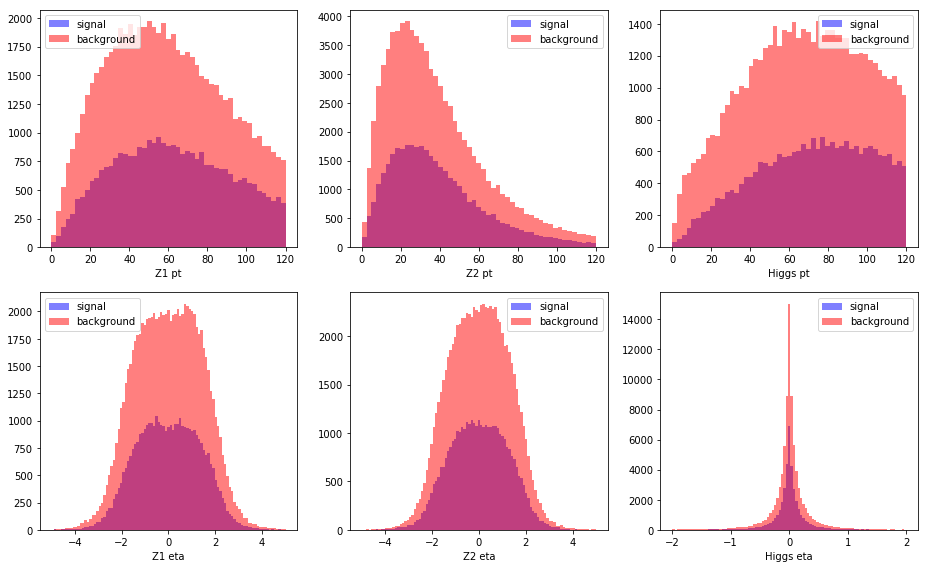

In [31]:
sz1pt = []
sz2pt = []
shpt = []
sz1eta = []
sz2eta = []
sheta = []
for i in range(len(full_event['signal'])):
    shpt.append( full_event['signal'][i][0][0] )
    sz1pt.append( full_event['signal'][i][1][0] )
    sz2pt.append( full_event['signal'][i][2][0] )
    sheta.append( full_event['signal'][i][0][1]-(full_event['signal'][i][1][1]+full_event['signal'][i][2][1])/2. )
    sz1eta.append( full_event['signal'][i][1][1] )
    sz2eta.append( full_event['signal'][i][2][1] )

bz1pt = []
bz2pt = []
bhpt = []
bz1eta = []
bz2eta = []
bheta = []
for i in range(len(full_event['background'])):
    bhpt.append( full_event['background'][i][0][0] )
    bz1pt.append( full_event['background'][i][1][0] )
    bz2pt.append( full_event['background'][i][2][0] )
    bheta.append( full_event['background'][i][0][1]-(full_event['background'][i][1][1]+full_event['background'][i][2][1])/2. )
    bz1eta.append( full_event['background'][i][1][1] )
    bz2eta.append( full_event['background'][i][2][1] )
    
fig = pyp.figure()
fig.set_figheight(8)
fig.set_figwidth(13)

fig1 = fig.add_subplot(231)
bins1 = np.linspace(0,120,50)
fig1 = pyp.hist(sz1pt, bins1, alpha=0.5, color='blue', label='signal' )
fig1 = pyp.hist(bz1pt, bins1, alpha=0.5, color='red', label='background' )
fig1 = pyp.xlabel('Z1 pt')
fig1 = pyp.legend(loc='upper left')

fig2 = fig.add_subplot(232)
bins2 = np.linspace(0,120,50)
fig2 = pyp.hist(sz2pt, bins2, alpha=0.5, color='blue', label='signal' )
fig2 = pyp.hist(bz2pt, bins2, alpha=0.5, color='red', label='background' )
fig2 = pyp.xlabel('Z2 pt')
fig2 = pyp.legend(loc='upper right')

fig3 = fig.add_subplot(233)
bins3 = np.linspace(0,120,50)
fig3 = pyp.hist(shpt, bins3, alpha=0.5, color='blue', label='signal' )
fig3 = pyp.hist(bhpt, bins3, alpha=0.5, color='red', label='background' )
fig3 = pyp.xlabel('Higgs pt')
fig3 = pyp.legend(loc='upper right')

fig4 = fig.add_subplot(234)
bins4 = np.linspace(-5,5,100)
fig4 = pyp.hist(sz1eta, bins4, alpha=0.5, color='blue', label='signal' )
fig4 = pyp.hist(bz1eta, bins4, alpha=0.5, color='red', label='background' )
fig4 = pyp.xlabel('Z1 eta')
fig4 = pyp.legend(loc='upper left')

fig5 = fig.add_subplot(235)
bins5 = np.linspace(-5,5,100)
fig5 = pyp.hist(sz2eta, bins5, alpha=0.5, color='blue', label='signal' )
fig5 = pyp.hist(bz2eta, bins5, alpha=0.5, color='red', label='background' )
fig5 = pyp.xlabel('Z2 eta')
fig5 = pyp.legend(loc='upper right')

fig6 = fig.add_subplot(236)
bins6 = np.linspace(-2,2,100)
fig6 = pyp.hist(sheta, bins6, alpha=0.5, color='blue', label='signal' )
fig6 = pyp.hist(bheta, bins6, alpha=0.5, color='red', label='background' )
fig6 = pyp.xlabel('Higgs eta')
fig6 = pyp.legend(loc='upper right')

pyp.tight_layout()
fig = pyp.show()

In [ ]:
#chose amount of pixels
nx = 36
xmin = -5
xmax = 5
ny = 36
ymin = -2
ymax = 2
proc = [True,True,True,False]

#create and show jet images
s_images, slist_x, slist_y, slist_w, sxbins, sybins = prepareImages(full_event['signal'], nx, xmin, xmax, ny, ymin, ymax, proc)

sall_x = np.concatenate(slist_x)
sall_y = np.concatenate(slist_y)
sall_w = np.concatenate(slist_w)
sall_w = 1.*sall_w/len(s_images) # to get average

b_images, blist_x, blist_y, blist_w, bxbins, bybins = prepareImages(full_event['background'], nx, xmin, xmax, ny, ymin, ymax, proc)

ball_x = np.concatenate(blist_x)
ball_y = np.concatenate(blist_y)
ball_w = np.concatenate(blist_w)
ball_w = 1.*ball_w/len(b_images) # to get average

fig = pyp.figure()
fig.set_figheight(6)
fig.set_figwidth(13)

fig1 = fig.add_subplot(121)
fig1 = pyp.hist2d(sall_x, sall_y, weights=sall_w, bins=(sxbins,sybins), norm=mpl.colors.LogNorm())
fig1 = pyp.colorbar()
fig1 = pyp.xlabel('eta')
fig1 = pyp.ylabel('phi')
fig1 = pyp.title('Signal Image')

fig2 = fig.add_subplot(122)
fig2 = pyp.hist2d(ball_x, ball_y, weights=ball_w, bins=(bxbins,bybins), norm=mpl.colors.LogNorm())
fig2 = pyp.colorbar()
fig2 = pyp.xlabel('eta')
fig2 = pyp.ylabel('phi')
fig2 = pyp.title('Background Image')

pyp.tight_layout()
fig = pyp.show()

In [27]:
# Model
def build_conv_model():
    input_layer = Input(shape=(1, nx, ny))
    layer = Convolution2D(8, 11, 11, border_mode='same')(input_layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    layer = Convolution2D(8, 6, 6, border_mode='same')(layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.20)(layer)
    layer = Dense(20)(layer)
    layer = Dropout(0.10)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    model = Model(input=input_layer, output=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

conv_model = build_conv_model()
conv_model.summary()

/home/micah/keras/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (11, 11), padding="same")`
  after removing the cwd from sys.path.
/home/micah/keras/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (6, 6), padding="same")`
  import sys
/home/micah/keras/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/micah/keras/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_1)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 36, 36)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 36, 36)         976       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 36, 36)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 18, 18)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 18, 18)         2312      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 18, 18)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 6, 6)           0         
__________

In [28]:
#prepare inputs for model
X = np.concatenate([s_images, b_images])
sY = np.ones(s_images.shape[0])
bY = np.zeros(b_images.shape[0])
Y = np.concatenate([sY, bY])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [29]:
# Train and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    conv_model = build_conv_model()
    history = conv_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), epochs=20, batch_size=256, verbose=2, callbacks=[early_stopping])
    Y_score = conv_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    pyp.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
pyp.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
pyp.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver operating characteristic example')
pyp.legend(loc="lower right")
pyp.show()

/home/micah/keras/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (11, 11), padding="same")`
  after removing the cwd from sys.path.
/home/micah/keras/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (6, 6), padding="same")`
  import sys
/home/micah/keras/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/micah/keras/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_2)`


Train on 3000 samples, validate on 3000 samples
Epoch 1/20
24s - loss: 0.7047 - acc: 0.5253 - val_loss: 0.6944 - val_acc: 0.5070
Epoch 2/20
23s - loss: 0.6879 - acc: 0.5400 - val_loss: 0.6925 - val_acc: 0.5223
Epoch 3/20
23s - loss: 0.6847 - acc: 0.5587 - val_loss: 0.6926 - val_acc: 0.5250
Epoch 4/20


KeyboardInterrupt: 

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    if K.image_dim_ordering()=='tf':
        x = x.transpose((1, 2, 0))
        x = x.transpose((1, 0, 2))
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# dimensions of the generated pictures for each filter.
img_width = nx
img_height = ny

layer_dict = dict([(layer.name, layer) for layer in conv_model.layers])
input_img = conv_model.input

pics = {}
num_filters = {}
for key, layer in layer_dict.iteritems():
    #if 'convolution2d' in key:
    if 'conv2d' in key:
        num_filters[key] = 8
        
layer_name = num_filters.keys()[1]

print num_filters.keys()
print layer_name # here we pick which layer to visualize

In [ ]:
kept_filters = []
for filter_index in range(0,num_filters[layer_name]):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering()=='tf':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    
    if K.image_dim_ordering()=='tf':
        input_img_data = np.random.random((1, img_width, img_height, 1))
    else:
        input_img_data = np.random.random((1, 1, img_width, img_height))
        
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 100 steps
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    # decode the resulting input image
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    
fig = pyp.figure(figsize=(15,15))
i = 0
j = 0
for img, loss  in kept_filters:
    i+=1
    fig.add_subplot(3,3,i)
    pyp.imshow(img[0])
    #pyp.colorbar()
    
pyp.tight_layout()
fig = pyp.show()